# Studying the orbit of satellite galaxies

The purpose of this tutorial is to help *you* with modelling and studying the orbit of galaxies. The [galpy documentation](https://docs.galpy.org/en/latest/index.html) is an excellent resource if you need to look into any methods in more detail.

There are a few things you need to consider when creating your model.
- **Firstly**: what data are you using? When you start your model, you need to have some data on the current 6D properties of your galaxy. The two main methods (that may either produce the same or different results) are 
    1. manually inputting the 6D data as a list, or 
   
    2. using the orbit.Orbit.from_name method. The from_name method imports the data from the SIMBAD database automatically. The astroquery package needs to be installed in order for SIMBAD to be queried, however galpy does also include a small list of objects saved which can be accessed by using tab completion with `Orbit.from_name('')`. 

- You can also instantiate multiple galaxies at once, by either inputting the 6D data as a multi-dimensional array, or by inputting a list of names (when using the from_name method). 3 collections of objects can also be loaded with from_name: *'MW globular clusters'*, *'MW satellite galaxies'*, and *'solar system'*.
- **Next**: what potential are you using for the Milky Way? the galpy package's default potential is 'MWPotential2014', which is described in detail in Bovy (2015), however it also includes others like McMillan17, from the McMillan (2017) paper, and more. You can also instantiate the potential from scratch, using different potential objects like the MiyamotoNagaiPotential.
- **And**: Do you want to include the LMC potential? The LMC's effects on the Milky Way influences the dynamics of neighbouring bodies, and depending on the distance from the Milky Way's centre, it's inclusion will affect how satellite galaxies orbit the Milky Way. You can either include it by making a simplified potential, ..... Or, you can include its affects on the acceleration of the Milky Way galactic centre, by calculating the resulting force of the LMC on the MW.
- **Lastly**: For what timeframe do you want to model your orbit? You can integrate your orbit forwards, backwards, or even both to compare the past modelled orbit to the predicted future orbit. You can also choose exactly how far back (or far forwards) you want to integrate the orbit, just keep in mind that the further you model from the present, the less accurate the model may become. Most of the time, integrating your galaxy just long enough for one full orbit is sufficient.

In [1]:
# Importing our libraries and packages required for the orbit
from galpy.orbit import Orbit
from galpy import potential
import numpy as np
import matplotlib.pyplot as plt
from galpy.util import conversion

# Importing potentials.
from galpy.potential import MWPotential2014,ChandrasekharDynamicalFrictionForce,HernquistPotential,MovingObjectPotential

## Instantiating our galaxy "Orbit"
The first thing that we do is create a galpy Orbit object that represents our satellite galaxy. If you're inputting the initial conditions by hand, you want to make sure that you're inputting it properly so that the orbit knows what values you're using. You can set it up with [R,vR,vT,z,vz,phi] coordinates very easily, in galpy internal units. You can use the conversion module to convert between these galpy units and physical units.
```python  
o = Orbit([R,vR,vT,z,vz,phi])
```
If you have [RA(deg),DEC(deg),Dist(kpc),$\mu_\alpha^*$(mas/yr), $\mu_\delta$(mas/yr),$v_{los}$(km/s)], you don't need to convert your data into other coordinates, and can instantiate simply;
```python
o = Orbit([ra,dec,d,mu_ra,mu_dec,vlos], radec=True)
```
Lastly, you can also instantiate the orbit with retrieved 6D conditions from SIMBAD. Keep in mind that the name query needs to be identical to how it is listed on the SIMBAD database;
```python
name = "my galaxy's name"
o = Orbit.from_name(name)
```

Sometimes, you may want to use physical coordinates immediately (.. write about ro and vo).
Or, you may want to use a different solar motion than the default. The default solar motion is from Schoenrich et al. (2010), where the solar motion [U,V,W] = **[11.1,12.24,7.25]**. You can input either 'hogg', 'dehnen', 'schoenrich', or the value in [-U,V,W]. **Note the minus sign in front of U when inputting the value manually**.

Also, if you need outputs to be in the natural galpy coordinates, you can include `o.turn_physical_off()` in your script. You can quickly convert between physical and galpy units by multiplying/dividing by galpy.unit.conversion methods; specific functions can be found in the [galpy docs](https://docs.galpy.org/en/latest/reference/conversion.html).

## Timescale choice
Now that the orbit has been initialized,our next step is to choose our timescale. This is not too important immediately, and can always be adjusted later. We choose how far we integrate, for example `t = 2` for 2Gyr, then we convert it into galpy units by introducing a conversion factor `to = conversion.time_in_Gyr(ro=ro, vo=vo)` *(I specify ro = 8kpc and vo = 220km/s)*. We also include how many time steps we'd like to integrate with `n=1001`. Lastly we decide whether we are integrating our orbit forwards or backwards, by simply defining our time array to increase from 0 (forwards) `ts= np.linspace(0.,t/to,n)`, or to decrease from 0 (backwards) `ts= np.linspace(0.,-t/to,n)` *(Notice the change in sign of 't')*.
This can be done using other methods, but the important thing is that we create an array that spans a timeframe including the initial time (current time, defined as t=0).

## Deciding on the potential
This is a very important step that will impact the result of the orbit model the most.
As mentioned previously, the first step is to decide what 'base' potential we are going to use for the Milky Way. Depending on the desired model, you can choose which Milky Way potential suits your needs. Check [galpy potentials doc](https://docs.galpy.org/en/latest/reference/potential.html) for more information on this.
If you don't specify a potential, the default will be MWPotential2014, which represents the sum of the halo and disk mass distributions, but does not include the supermassive black hole at the Galactic Centre.

### Are you including the LMC?
Including the effect of the LMC on the Milky Way introduces more realistic dynamics to the model. To include it, you first need to instantiate the LMC as an Orbit object, and then integrate it backwards along your timescale, assuming that it experiences dynamical friction from the Milky Way.
```python
mass_lmc=1.0e11 #solar masses
rscale_lmc=10.2 #kpc

o_lmc = Orbit.from_name('LMC', ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])
ts= np.linspace(0.,-t/to,1001)
cdf= ChandrasekharDynamicalFrictionForce(GMs=mass_lmc/mo, rhm=rscale_lmc/ro, dens=pot, ro=ro,vo=vo)
o_lmc.integrate(ts,pot+cdf)
```

Next, you represent the LMC as a moving object potential. We do this by first modelling it as a stationary Hernquist Potential, and then implement its motion by combining this potential with its integrated orbit. It can then be added to the potential of the Milky Way. 

```python
#Moving Hernquist potential represents the LMC
pot_lmc = HernquistPotential(mass_lmc/mo,rscale_lmc/ro,ro=ro,vo=vo)
moving_pot_lmc = MovingObjectPotential(o_lmc, pot_lmc,ro=ro,vo=vo)

#Add LMC potential to the MW
total_pot = [pot]
total_pot += [moving_pot_lmc]
```

Now this total potential, `total_pot`, can be used for your satellite orbit integration.

### Including the Milky Way centre's barycentric acceleration due to the LMC
Depending on the location of your satellite galaxy, this inclusion may not affect your orbit drastically, but it will still produce a more accurate result. We start by defining the functions that give the origin acceleration, in rectangular coordinates.
```python
from galpy.potential import (evaluateRforces, evaluatephitorques,
                                 evaluatezforces)
loc_origin= 1e-4 # Small offset in R to avoid numerical issues
ax= lambda t: evaluateRforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)
ay= lambda t: evaluatephitorques(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                    use_physical=False)/loc_origin
az= lambda t: evaluatezforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)
```

These are then interpolated to speed up the numerical calculations of the NonInertialFrameForce.

```python
t_intunits= o.time(use_physical=False)[::-1] # need to reverse the order for interp
ax4int= np.array([ax(t) for t in t_intunits])
ax_int= lambda t: np.interp(t,t_intunits,ax4int)
ay4int= np.array([ay(t) for t in t_intunits])
ay_int= lambda t: np.interp(t,t_intunits,ay4int)
az4int= np.array([az(t) for t in t_intunits])
az_int= lambda t: np.interp(t,t_intunits,az4int)
```

We now compute the potential addition due to the acceleration of the origin:

```python
from galpy.potential import NonInertialFrameForce
nip= NonInertialFrameForce(a0=[ax_int,ay_int,az_int])
```

Now we're left with three components of the total potential:
- MWPotential2014 (or whatever other potential you are using for the Milky Way)
- nip (The non-inertial potential)
- moving_pot_lmc (Our potential for the moving LMC)
The total potential can now be represented as `MwPotential2014 + nip + moving_pot_lmc` or `[MWPotential2014] + [nip] + [moving_pot_lmc]` (These methods are equivalent).

## Finally modelling the orbit of your galaxy
Now the orbit can be integrated with your timescale and potential of choice.
```python
o.integrate(timescale,potential)
```
You can now plot almost any dynamic property of the orbit, like cartesian coordinates, cylindrical coordinates, right ascension and declination, etc. You can find exactly what attributes you can find by either typing `o.` and hitting TAB, or by going to the [galpy orbit attributes](https://docs.galpy.org/en/latest/reference/orbit.html#attributes) found in the documentation.
Galpy has a method that will plot your coordinates of choice, `o.plot(d1, d2)`, where d1 and d2 are the first and second dimensions, or in 3D `o.plot(d1, d2, d3)`, or as an animation `o.animate(d1, d2)` over the integrated orbit. Galpy plotting methods also allow you to input all of the usual matplotlib arguments. For example, you can change the datapoint colour to black by including `c='k'`. 

You can also always create the plots manually by using `matplotlib.pyplot` methods like so:
```python
plt.plot(o.ra(ts), o.dec(ts), 'k-')
```
Which would produce a plot of your orbit in the RA-DEC projection. You can also model your data using a segment of the timescale ts, by indexing your values, ex. `o.ra(ts)[:len(ts)/2]` would plot your orbit for only the second half of your timescale. If you don't include 'ts' when plotting, only the current (t=0) values will be plotted.

### Including uncertainties
In order to include uncertainties from the 6D data when modeling the orbit, the simplest method is assuming that the data can be characterised by a gaussian distribution. Then, by using numpy or another method, random datapoints can be generated and used in the orbit integration. For example, if your generated data `sixD_unc` is in a 2D array of shape (30,6), then `Orbit(sixD_unc)` will generate a collection of 30 orbits. 

# Example notebook

In my example, I'll be modelling the orbit of the dwarf galaxy **Antlia II**.

In [5]:
## 6D Data and uncertainties from Dr. Andrew Pace's recent paper
sixD = [142.8868, -36.7673, 132, -0.093, 0.1, 290.7]
sigma = [0, 0, 6, 0.008, 0.009, 0.5]

pot = MWPotential2014
ro = 8.
vo = 220.
mo = conversion.mass_in_msol(ro=ro, vo=vo)
solarmotion = [-11.1, 12.24, 7.25]

# How many data points I want, taking into account the uncertainty
N_unc = 100
sixD_unc = np.random.normal(loc=sixD, scale=sigma, size = (N_unc,6))

In [6]:
# Initializing the orbits
o = Orbit(sixD, radec=True, solarmotion=solarmotion)
o_unc = Orbit(sixD_unc, radec=True, solarmotion=solarmotion)

In [7]:
# Initializing the timescale, so that I can integrate backwards 5Gyrs
t = 5
to = conversion.time_in_Gyr(ro=ro,vo=vo)
n = 1001
ts= np.linspace(0.,-t/to,n)

In [8]:
# Integrating the orbits
o.integrate(ts, pot=pot)
o_unc.integrate(ts, pot=pot)

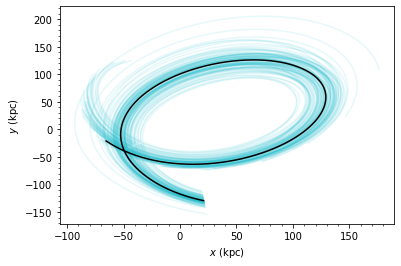

In [9]:
# Plotting.
o_unc.plot(d1='x', d2='y', alpha=0.1, c='#17becf')
o.plot(d1='x', d2='y', overplot=True, c='k')

### If I want to see how the LMC affects the orbit:

In [10]:
## Including the effects from the LMC:
mass_lmc=1.0e11 #solar masses
rscale_lmc=10.2 #kpc

o_lmc = Orbit.from_name('LMC', ro=ro, vo=vo, solarmotion=[-11.1, 24.0, 7.25])
ts= np.linspace(0.,-t/to,1001)
cdf= ChandrasekharDynamicalFrictionForce(GMs=mass_lmc/mo, rhm=rscale_lmc/ro, dens=pot, ro=ro,vo=vo)
o_lmc.integrate(ts,pot+cdf)

#Moving Hernquist potential represents the LMC
pot_lmc = HernquistPotential(mass_lmc/mo,rscale_lmc/ro,ro=ro,vo=vo)
moving_pot_lmc = MovingObjectPotential(o_lmc, pot_lmc,ro=ro,vo=vo)

#Add LMC potential to the MW
total_pot = [pot]
total_pot += [moving_pot_lmc]

In [11]:
from galpy.potential import (evaluateRforces, evaluatephitorques,
                                 evaluatezforces)
loc_origin= 1e-4 # Small offset in R to avoid numerical issues
ax= lambda t: evaluateRforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)
ay= lambda t: evaluatephitorques(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                    use_physical=False)/loc_origin
az= lambda t: evaluatezforces(moving_pot_lmc,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)

t_intunits= o.time(use_physical=False)[::-1] # need to reverse the order for interp
ax4int= np.array([ax(t) for t in t_intunits])
ax_int= lambda t: np.interp(t,t_intunits,ax4int)
ay4int= np.array([ay(t) for t in t_intunits])
ay_int= lambda t: np.interp(t,t_intunits,ay4int)
az4int= np.array([az(t) for t in t_intunits])
az_int= lambda t: np.interp(t,t_intunits,az4int)

from galpy.potential import NonInertialFrameForce
nip= NonInertialFrameForce(a0=[ax_int,ay_int,az_int])

In [12]:
newpot = pot + moving_pot_lmc + nip

In [13]:
# Integrating the orbits
o.integrate(ts, pot=newpot)
o_unc.integrate(ts, pot=newpot)

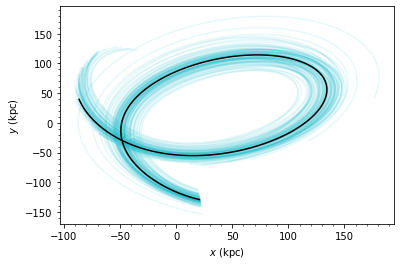

In [14]:
# Plotting.
o_unc.plot(d1='x', d2='y', alpha=0.1, c='#17becf')
o.plot(d1='x', d2='y', overplot=True, c='k')

### Below I'll include examples of the various (but not all) projections that can be plotted using the data kept in Orbit objects

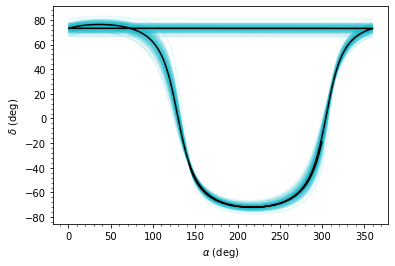

In [15]:
o_unc.plot(d1='ra', d2='dec', alpha=0.1, c='#17becf')
o.plot(d1='ra', d2='dec', overplot=True, c='k')

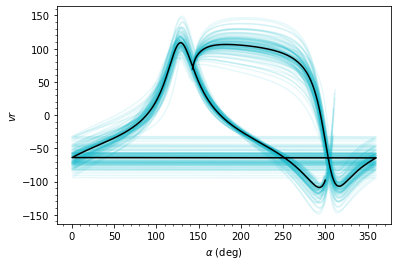

In [16]:
o_unc.plot(d1='ra', d2='vr', alpha=0.1, c='#17becf')
o.plot(d1='ra', d2='vr', overplot=True, c='k')

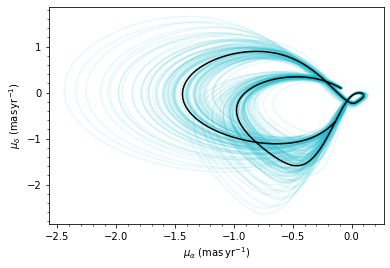

In [17]:
o_unc.plot(d1='pmra', d2='pmdec', alpha=0.1, c='#17becf')
o.plot(d1='pmra', d2='pmdec', overplot=True, c='k')

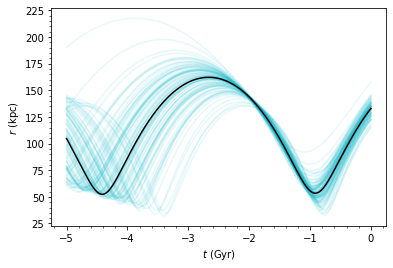

In [18]:
o_unc.plot(d1='t', d2='r', alpha=0.1, c='#17becf')
o.plot(d1='t', d2='r', overplot=True, c='k')

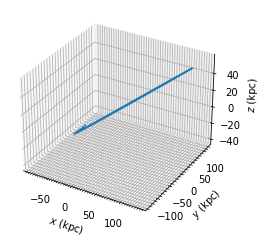

In [25]:
o.plot3d()

Text(0, 0.5, 'declination')

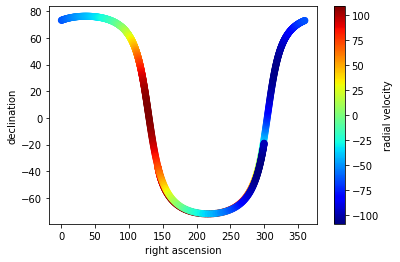

In [20]:
plt.scatter(x = o.ra(ts), y=o.dec(ts), c=o.vr(ts), cmap='jet')
plt.colorbar(label='radial velocity')
plt.xlabel('right ascension')
plt.ylabel('declination')